In [6]:
import os
import time
from osgeo import gdal
from utilis import *
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# 定義植生指標
VIs = ['NDVI', 'NDRE', 'NDI', 'RGI', 'ExG']

# 定義主要輸入文件夾
main_input_folder = '04_Result/Image/UC/ROI'
output_base_folder = '04_Result/Image/UC/ROI'

# 記錄總開始時間
total_start_time = time.time()

# 遍歷 ROI 資料夾中的所有日期資料夾
for i, date in enumerate(os.listdir(main_input_folder), 1):
    input_folder = os.path.join(main_input_folder, date, 'VI')
    output_folder_independent = os.path.join(output_base_folder, date, 'VI', 'Independent')
    source_folder = os.path.join(main_input_folder, date, 'tif')

    print('------------------------------')
    print(f"開始處理第 {i} 個資料夾，日期為:{date}")
    dir_maker(output_folder_independent)
    iter_start_time = time.time()

    for VI in VIs:
        for vi_file in os.listdir(input_folder):
            if VI in vi_file and vi_file.endswith('.tif'):
                input_vi_file = os.path.join(input_folder, vi_file)
                
                # 根據 VI 去掉前綴找到對應的 source_file
                base_filename = vi_file.replace(f'{VI}_', '')
                source_file = os.path.join(source_folder, base_filename)

                # 檢查 source_file 是否存在
                if not os.path.exists(source_file):
                    print(f"Source file {source_file} does not exist, skipping.")
                    continue

                # 讀取 TIFF 檔案
                dataset = gdal.Open(input_vi_file)
                band = dataset.GetRasterBand(1)
                vi_data = band.ReadAsArray()

                # 讀取 source_file 檔案作為 mask
                dataset_source = gdal.Open(source_file)
                if dataset_source is None:
                    print(f"Failed to open {source_file}, skipping.")
                    continue
                
                try:
                    mask_band = dataset_source.GetRasterBand(7)
                except RuntimeError as e:
                    print(f"Failed to get raster band: {e}, skipping.")
                    continue

                mask_data = mask_band.ReadAsArray()

                # 檢查 mask_data 的形狀與 vi_data 是否一致
                if mask_data.shape != vi_data.shape:
                    print(f"Shape mismatch for {vi_file}: mask_data shape {mask_data.shape}, vi_data shape {vi_data.shape}")
                    continue

                mask = mask_data != 0

                # 把紅色框框的區域設為 NaN
                vi_data_masked = np.where(~mask, np.nan, vi_data)

                # 計算非零平均值（只在有圖的範圍內）
                non_zero_values = vi_data_masked[(vi_data_masked != 0) & (~np.isnan(vi_data_masked))]
                mean_value = np.mean(non_zero_values)

                # 用非零平均值填補綠框內的0值
                vi_data_filled = np.where((vi_data_masked == 0) & mask, mean_value, vi_data_masked)

                # 創建顏色圖譜，將 NaN 值設置為透明
                cmap = plt.get_cmap('RdYlGn')
                cmap = cmap(np.arange(cmap.N))
                cmap[:, -1] = np.where(np.isnan(cmap[:, -1]), 0, 1)  # 設置透明度
                transparent_cmap = mcolors.ListedColormap(cmap)

                # 顯示圖像並保存成 PNG 檔案（個別檔案）
                individual_start_time = time.time()
                fig, ax = plt.subplots()
                im = ax.imshow(vi_data_filled, cmap=transparent_cmap, vmin=0, vmax=1)
                ax.axis('off')  # 關閉X、Y軸
                ax.set_frame_on(False)  # 去掉框框
                output_png_file_independent = os.path.join(output_folder_independent, vi_file.replace('.tif', '.png'))
                plt.savefig(output_png_file_independent, bbox_inches='tight', pad_inches=0, transparent=True)
                plt.close()
                individual_end_time = time.time()
                print(f'{date}_{VI}_{base_filename} 檔案處理花費時間: {individual_end_time - individual_start_time:.2f} 秒')

    iter_end_time = time.time()
    print(f"第 {i} 個資料夾處理結束，花費時間: {iter_end_time - iter_start_time:.2f} 秒")
    print('------------------------------')
    print()

# 計算並顯示總時間
total_end_time = time.time()
print(f'處理完成，共花費時間: {total_end_time - total_start_time:.2f} 秒')


------------------------------
開始處理第 1 個資料夾，日期為:20240415
20240415_NDVI_乾旱處理_(DD_1)_0.tif 檔案處理花費時間: 2.04 秒
20240415_NDVI_乾旱處理_(DD_2)_0.tif 檔案處理花費時間: 1.29 秒
20240415_NDVI_對照組_(CK)_0.tif 檔案處理花費時間: 2.80 秒
20240415_NDRE_乾旱處理_(DD_1)_0.tif 檔案處理花費時間: 2.04 秒
20240415_NDRE_乾旱處理_(DD_2)_0.tif 檔案處理花費時間: 1.33 秒
20240415_NDRE_對照組_(CK)_0.tif 檔案處理花費時間: 2.79 秒
20240415_NDI_乾旱處理_(DD_1)_0.tif 檔案處理花費時間: 2.02 秒
20240415_NDI_乾旱處理_(DD_2)_0.tif 檔案處理花費時間: 1.39 秒
20240415_NDI_對照組_(CK)_0.tif 檔案處理花費時間: 2.77 秒
20240415_RGI_乾旱處理_(DD_1)_0.tif 檔案處理花費時間: 2.04 秒
20240415_RGI_乾旱處理_(DD_2)_0.tif 檔案處理花費時間: 1.34 秒
20240415_RGI_對照組_(CK)_0.tif 檔案處理花費時間: 2.83 秒
20240415_ExG_乾旱處理_(DD_1)_0.tif 檔案處理花費時間: 2.02 秒
20240415_ExG_乾旱處理_(DD_2)_0.tif 檔案處理花費時間: 1.33 秒
20240415_ExG_對照組_(CK)_0.tif 檔案處理花費時間: 2.80 秒
第 1 個資料夾處理結束，花費時間: 64.78 秒
------------------------------

------------------------------
開始處理第 2 個資料夾，日期為:20240513
20240513_NDVI_乾旱處理_(DD_1)_0.tif 檔案處理花費時間: 2.13 秒
20240513_NDVI_乾旱處理_(DD_2)_0.tif 檔案處理花費時間: 1.62 秒
20240513_NDVI_對照組_

In [8]:
import os
import time
from osgeo import gdal
from utilis import *
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# 定義植生指標
VIs = ['NDVI', 'NDRE', 'NDI', 'RGI', 'ExG']

# 定義主要輸入文件夾
main_input_folder = '04_Result/Image/UC/ROI'
output_base_folder = '04_Result/Image/UC/ROI'

# 記錄總開始時間
total_start_time = time.time()

# 遍歷 ROI 資料夾中的所有日期資料夾
for i, date in enumerate(os.listdir(main_input_folder), 1):
    input_folder = os.path.join(main_input_folder, date, 'VI')
    output_folder_independent = os.path.join(output_base_folder, date, 'VI', 'Independent')
    source_folder = os.path.join(main_input_folder, date, 'tif')

    print('------------------------------')
    print(f"開始處理第 {i} 個資料夾，日期為:{date}")
    dir_maker(output_folder_independent)
    iter_start_time = time.time()

    for VI in VIs:
        for vi_file in os.listdir(input_folder):
            if VI in vi_file and vi_file.endswith('.tif'):
                input_vi_file = os.path.join(input_folder, vi_file)
                
                # 根據 VI 去掉前綴找到對應的 source_file
                base_filename = vi_file.replace(f'{VI}_', '')
                source_file = os.path.join(source_folder, base_filename)

                # 檢查 source_file 是否存在
                if not os.path.exists(source_file):
                    print(f"Source file {source_file} does not exist, skipping.")
                    continue

                # 讀取 TIFF 檔案
                dataset = gdal.Open(input_vi_file)
                band = dataset.GetRasterBand(1)
                vi_data = band.ReadAsArray()

                # 讀取 source_file 檔案作為 mask
                dataset_source = gdal.Open(source_file)
                if dataset_source is None:
                    print(f"Failed to open {source_file}, skipping.")
                    continue
                
                try:
                    mask_band = dataset_source.GetRasterBand(7)
                except RuntimeError as e:
                    print(f"Failed to get raster band: {e}, skipping.")
                    continue

                mask_data = mask_band.ReadAsArray()

                # 檢查 mask_data 的形狀與 vi_data 是否一致
                if mask_data.shape != vi_data.shape:
                    print(f"Shape mismatch for {vi_file}: mask_data shape {mask_data.shape}, vi_data shape {vi_data.shape}")
                    continue

                mask = mask_data != 0

                # 把紅色框框的區域設為 NaN
                vi_data_masked = np.where(~mask, np.nan, vi_data)

                # 創建顏色圖譜，將 NaN 值設置為透明
                cmap = plt.get_cmap('RdYlGn')
                cmap = cmap(np.arange(cmap.N))
                cmap[:, -1] = np.where(np.isnan(cmap[:, -1]), 0, 1)  # 設置透明度
                transparent_cmap = mcolors.ListedColormap(cmap)

                # 顯示圖像並保存成 PNG 檔案（個別檔案）
                individual_start_time = time.time()
                fig, ax = plt.subplots()
                im = ax.imshow(vi_data_filled, cmap=transparent_cmap, vmin=0, vmax=1)
                ax.axis('off')  # 關閉X、Y軸
                ax.set_frame_on(False)  # 去掉框框
                output_png_file_independent = os.path.join(output_folder_independent, vi_file.replace('.tif', '.png'))
                plt.savefig(output_png_file_independent, bbox_inches='tight', pad_inches=0, transparent=True)
                plt.close()
                individual_end_time = time.time()
                print(f'{date}_{VI}_{base_filename} 檔案處理花費時間: {individual_end_time - individual_start_time:.2f} 秒')
    break
    iter_end_time = time.time()
    print(f"第 {i} 個資料夾處理結束，花費時間: {iter_end_time - iter_start_time:.2f} 秒")
    print('------------------------------')
    print()

# 計算並顯示總時間
total_end_time = time.time()
print(f'處理完成，共花費時間: {total_end_time - total_start_time:.2f} 秒')


------------------------------
開始處理第 1 個資料夾，日期為:20240415
20240415_NDVI_乾旱處理_(DD_1)_0.tif 檔案處理花費時間: 2.95 秒
20240415_NDVI_乾旱處理_(DD_2)_0.tif 檔案處理花費時間: 2.75 秒
20240415_NDVI_對照組_(CK)_0.tif 檔案處理花費時間: 3.13 秒
20240415_NDRE_乾旱處理_(DD_1)_0.tif 檔案處理花費時間: 2.75 秒
20240415_NDRE_乾旱處理_(DD_2)_0.tif 檔案處理花費時間: 2.69 秒
20240415_NDRE_對照組_(CK)_0.tif 檔案處理花費時間: 2.72 秒
20240415_NDI_乾旱處理_(DD_1)_0.tif 檔案處理花費時間: 2.77 秒
20240415_NDI_乾旱處理_(DD_2)_0.tif 檔案處理花費時間: 2.77 秒
20240415_NDI_對照組_(CK)_0.tif 檔案處理花費時間: 2.71 秒
20240415_RGI_乾旱處理_(DD_1)_0.tif 檔案處理花費時間: 2.72 秒
20240415_RGI_乾旱處理_(DD_2)_0.tif 檔案處理花費時間: 2.74 秒
20240415_RGI_對照組_(CK)_0.tif 檔案處理花費時間: 2.75 秒
20240415_ExG_乾旱處理_(DD_1)_0.tif 檔案處理花費時間: 2.72 秒
20240415_ExG_乾旱處理_(DD_2)_0.tif 檔案處理花費時間: 2.69 秒
20240415_ExG_對照組_(CK)_0.tif 檔案處理花費時間: 2.72 秒
處理完成，共花費時間: 71.36 秒


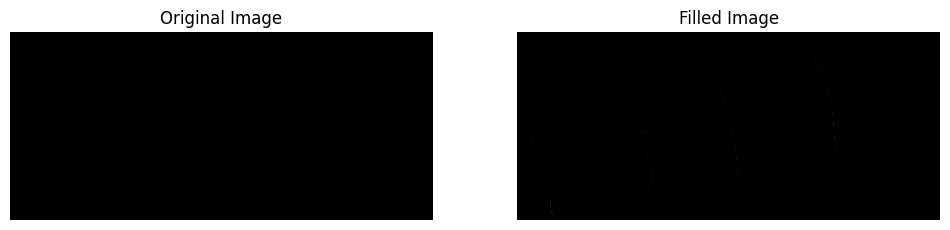

In [14]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# 讀取圖像
image_path = r'04_Result\Image\UC\ROI\20240415\VI\RGI_對照組_(CK)_0.tif'
image = Image.open(image_path).convert('L')
image_array = np.array(image)

# 檢查是否有缺值（假設缺值為 255）
def find_missing_values(image):
    return np.where(image == 255)

# 使用鄰近的值填補缺值
def fill_missing_values(image, missing_coords):
    filled_image = image.copy()
    for coord in zip(*missing_coords):
        neighborhood = image[max(0, coord[0]-1):min(image.shape[0], coord[0]+2),
                             max(0, coord[1]-1):min(image.shape[1], coord[1]+2)]
        if np.any(neighborhood != 255):
            filled_image[coord] = np.mean(neighborhood[neighborhood != 255])
        else:
            filled_image[coord] = 0  # 如果附近沒有非 255 的值，則設為 0
    return filled_image

# 找到缺值並填補
missing_coords = find_missing_values(image_array)
filled_image_array = fill_missing_values(image_array, missing_coords)

# 顯示原圖和填補後的圖像
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image_array, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(filled_image_array, cmap='gray')
axes[1].set_title('Filled Image')
axes[1].axis('off')

plt.show()
